In [9]:
#
# Import de toda la ejecucion
#
%matplotlib inline

from qiskit import *
from qiskit.providers.aer import noise
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [8]:
# Conexion al ordenador de melbourne
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

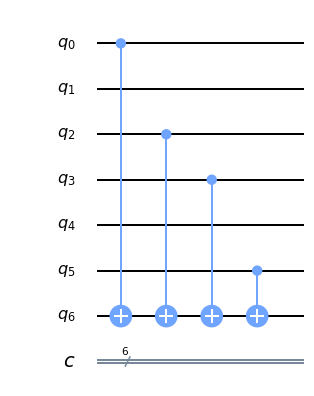

In [11]:
#
# Circuito a implememtar
#
secret_number = '101101'
secret_length = len(secret_number)
secret_range = range(secret_length)

bb = QuantumCircuit(secret_length + 1, secret_length)
for ii, yesno in enumerate(reversed(secret_number)):
    if yesno == '1':
        bb.cx(ii, secret_length)

bb.draw(output='mpl')

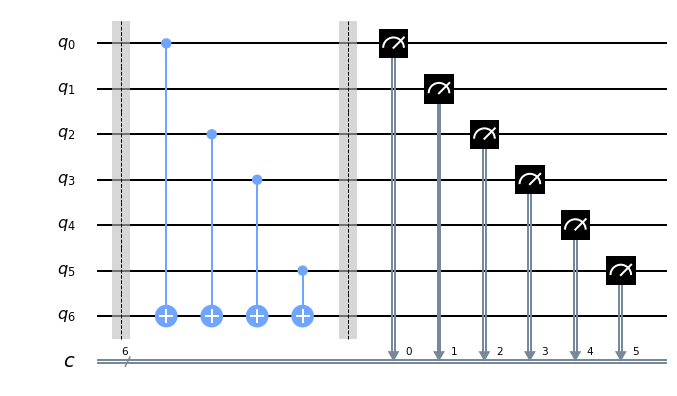

In [13]:
#
# Circuito de medicion (no tocar)
#
circuit = QuantumCircuit(secret_length + 1, secret_length)
circuit.barrier()
circuit +=bb
circuit.barrier()
circuit.measure(secret_range, secret_range)

circuit.draw(output='mpl')

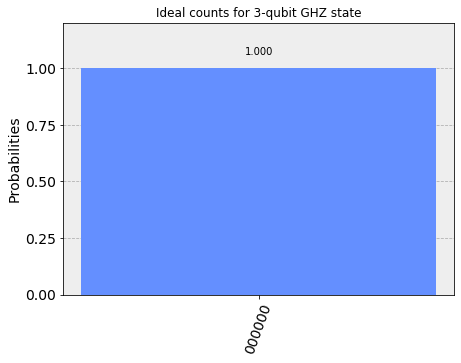

In [15]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circuit, simulator).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [17]:
# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate
# times are the same for all qubits
gate_times = [
    ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
    ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
    ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
    ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
    ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
    ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
    ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
]

# Construct the noise model from backend properties
# and custom gate times
noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 3]), ('cx', [4, 3]), ('cx', [4, 10]), ('cx', [5, 4]), ('cx', [5, 6]), ('cx', [5, 9]), ('cx', [6, 8]), ('cx', [7, 8]), ('cx', [9, 8]), ('cx', [9, 10]), ('cx', [11, 3]), ('cx', [11, 10]), ('cx', [11, 12]), ('cx', [12, 2]), ('cx', [13, 1]), ('cx', [13, 12]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), 

C:\Users\ilarburu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:112: DeprecationWarning: gate_times kwarg is deprecated and will be removed in a future release. Use gate_lengths kwarg instead.
  DeprecationWarning)


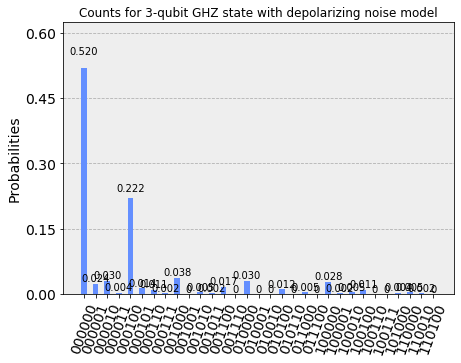

In [18]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator2 = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circuit, simulator2, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circuit)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")

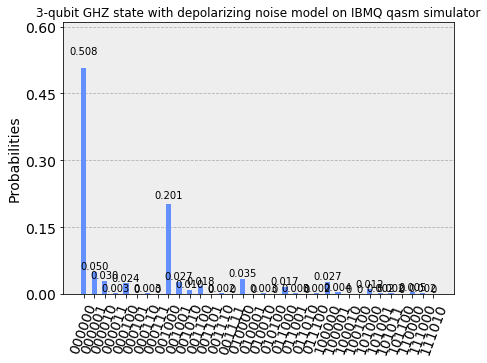

In [19]:
# Select the ibmq_qasm_simulator from the IBMQ provider
simulator3 = provider.get_backend('ibmq_qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circuit, simulator3, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circuit)
plot_histogram(counts_noise, title="3-qubit GHZ state with depolarizing noise model on IBMQ qasm simulator")

Job Status: job has successfully run


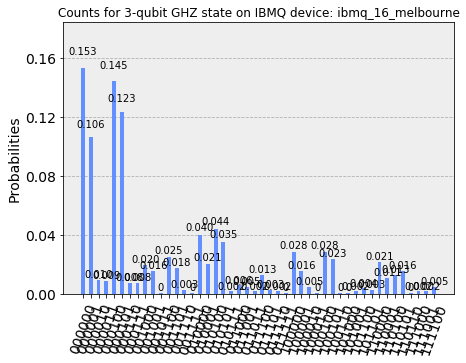

In [21]:
# Submit job to real device and wait for results
job_device = execute(circuit, device)
job_monitor(job_device)

# Get results from completed execution
result_device = job_device.result()
counts_device = result_device.get_counts(0)
plot_histogram(counts_device, title='Counts for 3-qubit GHZ state on IBMQ device: {}'.format(device.name()))